## Initial plan for training an SAE on spikes and trying to find interpretable SAE features

- [x] Get neural + behavioral data
  - [x] Get Allen visual coding neuropixels spikes data
  - [x] Get Allen visual stim data + metadata
- Train SAEs 
  - [x] Break spikes down into time windows
  - [x] Train SAEs on all spikes for a particular region for all sessions for one animal
- [x] Interpret SAE features
  - [x] After training, feed in spikes for particular time window(s) and see which SAE feature(s) fire, and see if they correspond to the visual stim
- Validate SAEs
  - [x] Visualize reconstructions
  - [x] Validate reconstructions (e.g. cosine similarity between reconstructions and true spikes)
  - [x] Validate sparsity (% active features over % time active)


## Example MINI pipeline on new data:

- Train/val/test split
- Train + hyperparam sweep SAE with k-fold crossval
- Validate SAE (on train + val data)
    - Validate that SAE features are sparse
      - Histogram of L0 (prob active for % of active features)
    - Validate that reconstructions are good
      - $R^2$ for total number of spikes summed over all neurons for each example
      - Cosine similarity for vector of reconstructions to vector of actual for each example
- Find k top-ranked SAE features (e.g. features with the highest mean N activation values, or features that are most important to reconstruction (i.e. when removed, reconstruction suffers the most) )
  - For each top-k SAE feature, (semi-automatically?) scour data / metadata to find corresponding natural feature
    - Essentially create a confusion matrix for natural vs. SAE feature: for all occurrences of natural feature, see co-occurrence rate of top-responding SAE features; for all occurrences of SAE feature, see co-occurrence rate of natural feature
- Validate top-k SAE features (on test data)
    - Again create natural vs. SAE feature confusion matrix, as was done above for train + val data
    - Show that the neurons and spikes that contribute to an SAE feature can decode the natural feature:
      - Roughly equivalent to decoding that takes into account *all* spikes ? 
      - OR (only do the following if the above fails) better than
        1. The top n neurons most correlated (highest firing) with the natural feature
        2. And/or the top n neurons that contribute to the SAE feature


### Two types of usecases

1. Given neural and behavioral data, find novel natural features encoded by characteristic neural activity patterns (found via SAE features) - this could be semi-automated

2. Given a set of natural features, see if there are neural activity patterns (via SAE features) that encode them - this could be fully automated! (but is not that different than doing something like a linear bayesian decoder)

## Initial Sweeps

This is all assuming 100-400 units over ~ 2e5 to 1e6 examples.

### Neural data

- Time window size (50 ms -- fixed for now)
- Unit preprocessing (remove units with firing rate < 0.5 Hz, isi violations > 0.1 -- fixed for now)
- Sequence length -- feed in previous info, but only try to reconstruct current info: (0 - 4 previous windows)

### SAEs

- Number of neurons: (5e3, 1e4, 2e4, 4e4)
- Optimizer learning rate: (lr: 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
- LR schedule (simple cosine cycle): (true, false)
- Loss functions
    - Batchtopk SAE (k: 25, 50, 100, 200)
        - L2 loss MSE
        - L2 loss msle (t: 0.9, 0.95, 1, 1.05, 1.1)

Report during sweep (at log_freq and after final step):

- plots
    - loss over time
    - for l0 distribution per batch: std over mean alphaed by time (0.5 - 1 (max_steps))
    - frac_dead over time

Report end of sweep:

- plots
    - histogram of L0 over all examples (print mean and std in title)
    - histogram of cosine similarity of reconstructions to true spikes over all examples (print mean and std in title)
    - boxplot of R^2 for each neuron over all examples
- numerics
    - R^2 of summed spike counts


---

One job (sweep) for each loss for each d_sae-topk pair -- 16 sweeps: 6 * 2 * 6 = 72 runs per sweep

## Secondary sweeps

(Based off of results from initial sweeps)

- d_sae: 4096, 8192, 16384, 32768, 65536
- topk: 32, 64, 128, 256
- lr: [1e-4, 5e-3]
- loss: msle_1.1, msle_1, msle_0.9

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [ ]:
"""Import packages."""

import math
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt

## Get Allen visual coding neuropixels data

In [3]:
"""Set paths."""

out_dir = Path(r"C:\Users\jai\mini\data")
out_dir.mkdir(exist_ok=True)
print(f"{out_dir.exists()=}")

manifest_path = out_dir / "manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

out_dir.exists()=True


In [4]:
movie_one = cache.get_natural_movie_template(1)
movie_three = cache.get_natural_movie_template(3)
image_117 = cache.get_natural_scene_template(117)

movie_one.shape, movie_three.shape, image_117.shape

((900, 304, 608), (3600, 304, 608), (918, 1174))

In [4]:
"""Get metadata."""

units = cache.get_units()
probes = cache.get_probes()
channels = cache.get_channels()
sessions = cache.get_session_table()

In [5]:
sessions[np.logical_and(sessions["unit_count"] > 800, sessions["session_type"] == "brain_observatory_1.1")]

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
750332458,2019-10-03T00:00:00Z,726141251,brain_observatory_1.1,91.0,M,wt/wt,902,2216,6,"[grey, VISrl, nan, VISal, IntG, IGL, LGd, CA3,..."
751348571,2019-10-03T00:00:00Z,732548380,brain_observatory_1.1,93.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,859,2217,6,"[grey, LGv, CA3, DG, CA1, VISl, nan, APN, POL,..."
754829445,2019-10-03T00:00:00Z,726298253,brain_observatory_1.1,141.0,M,wt/wt,832,1851,5,"[PoT, LP, LGd, CA3, DG, CA1, VISp, nan, VPM, C..."
757216464,2019-10-03T00:00:00Z,733457989,brain_observatory_1.1,105.0,M,wt/wt,959,2225,6,"[LP, DG, CA3, CA1, VISrl, nan, PO, LGd, HPF, V..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."


In [5]:
"""Choose a session and load in the data."""

# session = sessions[sessions["specimen_id"] == 742951821]
# session = sessions[sessions["specimen_id"] == 750332458]
# session = sessions[sessions["specimen_id"] == 717038288]
session = sessions[sessions.index == 732592105]
display(session)
session_id = session.index.values[0]
print(f"{session_id=}")
session_data = cache.get_session_data(session_id)

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"


session_id=732592105


c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Some useful (not exhaustive) `session_data` attributes and methods

- Attributes:
  - metadata
  - channels
  - stimulus_conditions
  - stimulus_presentations
  - spike_times
  - spike_amplitudes

- Methods:
  - channel_structure_intervals
  - conditionwise_spike_statistics
  - get_pupil_data 
  - get_stimulus_epochs
  - get_stimulus_parameter_values
  - get_stimulus_table
  - get_lfp
  - get_screen_graze_data
  - get_invalid_times
  - presentationwise_spike_times
  - presentationwise_spike_counts
  - running_speed

In [ ]:
display(session_data.metadata)

In [7]:
"""View units metadata."""

regions = ["VISp", "VISpm", "VISl", "VISli", "VISrl", "VISal"]
units_df = session_data.units
region_units = units_df[units_df["structure_acronym"].isin(regions)]
display(region_units)

c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loa

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
915957872,2.347448,91.248690,0.051478,307,588.13,5.808960,9.636760,0.046729,101.134751,5.542568e-04,...,533.0,VISpm,NaN,NaN,NaN,probeB,See electrode locations,29999.915391,1249.996475,True
915957896,0.381370,378.253395,0.001389,311,34.29,6.785946,1.114986,0.000000,82.101026,3.279392e-05,...,533.0,VISpm,NaN,NaN,NaN,probeB,See electrode locations,29999.915391,1249.996475,True
915957941,0.527115,247.121940,0.000013,321,53.14,3.402991,2.121415,0.000000,83.152709,1.080473e-04,...,533.0,VISpm,NaN,NaN,NaN,probeB,See electrode locations,29999.915391,1249.996475,True
915957936,0.599006,169.761540,0.000458,320,73.82,4.816514,5.329349,0.008410,75.592604,1.330984e-03,...,533.0,VISpm,NaN,NaN,NaN,probeB,See electrode locations,29999.915391,1249.996475,True
915958814,0.313378,77.694435,0.062824,490,337.16,2.840367,0.922304,0.046803,47.976359,4.389540e-03,...,533.0,VISpm,NaN,NaN,NaN,probeB,See electrode locations,29999.915391,1249.996475,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915967016,0.414487,436.516860,0.000049,541,198.98,9.276081,0.556161,0.000000,161.832812,2.757972e-07,...,417.0,VISrl,NaN,NaN,NaN,probeF,See electrode locations,30000.035326,1250.001472,True
915966905,0.452658,311.612340,0.000086,504,94.19,6.484525,0.321205,0.000000,62.475553,4.187439e-04,...,417.0,VISrl,NaN,NaN,NaN,probeF,See electrode locations,30000.035326,1250.001472,True
915966969,0.097593,92.764620,0.017205,525,227.54,3.324496,0.219342,0.000000,40.431213,6.794884e-03,...,417.0,VISrl,NaN,NaN,NaN,probeF,See electrode locations,30000.035326,1250.001472,True


In [10]:
region_units.columns

Index(['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff',
       'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate',
       'isi_violations', 'isolation_distance', 'L_ratio', 'local_index',
       'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id',
       'presence_ratio', 'waveform_recovery_slope',
       'waveform_repolarization_slope', 'silhouette_score', 'snr',
       'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below',
       'waveform_duration', 'filtering', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'ecephys_structure_id',
       'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate',
       'probe_description', 'location', 'probe_sampling_rate',
       'probe_lfp_sampling_rate', 'probe_has_lfp_data'],
      dtype='object')

In [9]:
region_units = region_units[region_units["firing_rate"] > 0.5]
region_units = region_units[region_units["isi_violations"] < 0.1]
print(len(region_units))

226


In [ ]:
"""Get spikes for units within specified region."""

spike_times = session_data.spike_times
region_unit_ids = set(region_units.index)
cluster_ids = set(region_units["cluster_id"])
region_spike_times = {
    unit_id: spikes
    for unit_id, spikes in spike_times.items()
    if unit_id in region_unit_ids
}
display(region_spike_times)

c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace

{915957951: array([  58.43389839,   68.84436109,   69.12766189, ..., 9369.23959097,
        9369.37909136, 9369.74325905]),
 915957946: array([1.02166981e+00, 1.17723691e+00, 2.50844067e+00, ...,
        9.41225195e+03, 9.41295741e+03, 9.41401995e+03]),
 915958108: array([2.46310720e+00, 2.47744058e+00, 2.49017395e+00, ...,
        9.41411768e+03, 9.41413028e+03, 9.41417902e+03]),
 915958104: array([5.43268457e-01, 6.58268781e-01, 7.72535770e-01, ...,
        9.41432605e+03, 9.41462439e+03, 9.41500369e+03]),
 915958534: array([  19.73718926,   19.86865629,   20.46919132, ..., 9381.51522559,
        9382.46512827, 9382.47446163]),
 915958067: array([8.13002551e-01, 8.81669411e-01, 9.67669654e-01, ...,
        9.41464459e+03, 9.41494712e+03, 9.41503029e+03]),
 915958058: array([6.45321846e+00, 7.36602103e+00, 1.96723224e+01, ...,
        9.41163018e+03, 9.41422225e+03, 9.41426812e+03]),
 915958122: array([1.46983774e+00, 1.60283811e+00, 1.73673849e+00, ...,
        9.40574093e+03, 9.4088

In [12]:
"""See total number of spikes, and the maximum number of spikes in a single unit."""

region_unit_spike_counts = {len(ts) for ts in region_spike_times.values()}
sum(region_unit_spike_counts), max(region_unit_spike_counts)

(16437523, 458062)

Options for feeding in spikes:
- Total spike counts per unit in a small time window

In [13]:
"""Format spikes data for SAE: binned spike counts."""

win = 0.05  # seconds
stop_time = session_data.stimulus_presentations.iloc[-1]["stop_time"]
time_bins = np.arange(0, stop_time, win)

# Get spike counts for all units for each timebin via histogram2d
all_spike_ts = np.concatenate(list(region_spike_times.values()))
unit_indices = np.concatenate(  # for each spike
    [np.full(len(spikes), i) for i, spikes in enumerate(region_spike_times.values())]
)
unit_bins = np.arange(len(region_spike_times) + 1)
counts, _, _ = np.histogram2d(
    all_spike_ts, unit_indices, bins=[time_bins, unit_bins]
)
counts = t.from_numpy(counts.astype(np.uint8))
n_examples, n_units = counts.shape

c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [14]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = t.sum(counts > 0) / counts.numel()
spike_counts_per_bin = reduce(counts, "example unit -> example", "sum")
frac_nonzero_examples = sum(spike_counts_per_bin > 0) / spike_counts_per_bin.shape[0]
print(f"{frac_nonzero_bins=}\n{frac_nonzero_examples=}")

frac_nonzero_bins=tensor(0.2521)
frac_nonzero_examples=tensor(0.9993)


In [15]:
"""Convert to sparse tensor."""

# Get nonzero idxs in appropriate format for `sparse_coo_tensor`
idxs = rearrange(t.nonzero(counts), "example orig_coord -> orig_coord example")
vals = counts[idxs[0], idxs[1]]
counts = t.sparse_coo_tensor(idxs, vals, t.Size(counts.shape))
print(counts)

tensor(indices=tensor([[     9,     10,     10,  ..., 182867, 182867, 182867],
                       [   136,      3,     39,  ...,    221,    222,    225]]),
       values=tensor([1, 1, 1,  ..., 1, 1, 3]),
       size=(182868, 226), nnz=10419845, dtype=torch.uint8,
       layout=torch.sparse_coo)


In [16]:
"""View binned spike counts as df."""

counts_df = pd.DataFrame(
    counts.to_dense(),
    columns=region_spike_times.keys(),  # unit IDs as column names
    index=time_bins[:-1],  # bin start times as index
)

display(counts_df)

,915957951,915957946,915958108,915958104,915958534,915958067,915958058,915958122,915958824,915958211,...,915966384,915966556,915966611,915966322,915966645,915966529,915966526,915966523,915966568,915966387
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143.15,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,2
9143.20,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,3
9143.25,1,2,0,5,0,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
9143.30,0,0,0,1,0,0,0,0,2,1,...,0,0,0,0,0,1,0,1,0,4


In [17]:
"""Save `counts_df`."""

save_dir = out_dir / "sessions_proc" / str(session_id)
save_dir.mkdir(parents=True, exist_ok=True)
counts_df.to_csv(save_dir / "spike_counts.csv")

In [6]:
"""Load `counts_df`."""

save_dir = out_dir / "sessions_proc" / str(session_id)
counts_df = pd.read_csv(save_dir / "spike_counts.csv", index_col=0)
display(counts_df)

,915957951,915957946,915958108,915958104,915958534,915958067,915958058,915958122,915958824,915958211,...,915966384,915966556,915966611,915966322,915966645,915966529,915966526,915966523,915966568,915966387
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143.15,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,2
9143.20,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,3
9143.25,1,2,0,5,0,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
9143.30,0,0,0,1,0,0,0,0,2,1,...,0,0,0,0,0,1,0,1,0,4


## Train the SAE

In [7]:
"""Check torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")
if device.type == "cuda":
    mem_gb_free = (
        t.cuda.get_device_properties(device).total_memory / 1e9
        - (t.cuda.memory_allocated(device) / 1e9) + (t.cuda.memory_reserved(device) / 1e9)
        )
    print(t.cuda.get_device_name(0))
    print(f"{mem_gb_free=:.2f}")

device=device(type='cuda')
NVIDIA GeForce RTX 3090
mem_gb_free=25.77


In [8]:
"""Estimate gb required for largest tensor op."""

n_units = counts_df.shape[1]
batch_sz, n_instances, seq_len, n_hidden_ae = 256, 2, 1, 10_000

# matmul for encoder (equivalent to decoder)
(
    (batch_sz * n_instances * n_units * seq_len) 
    + (n_instances * n_units * n_hidden_ae * seq_len) 
    + (batch_sz * n_instances * n_hidden_ae * seq_len) 
    * 2
) / 1e9

0.014875712

In [9]:
"""Create SAE for taking binned spike counts."""

@dataclass
class SaeConfig:
    """Config class to set some params for SAE."""
    n_input_ae: int  # number of input units to the autoencoder
    n_hidden_ae: int  # number of h_ae units in the autoencoder
    seq_len: int = 1  # number of time bins in a sequence
    n_instances: int = 2  # number of model instances to optimize in parallel
    topk: Optional[int] = None  # avg num of contributing sae features per example in a batch


class Sae(nn.Module):
    """SAE model for learning sparse representations of binned spike counts."""
    # Shapes of weights and biases for the encoder and decoder in the single-layer SAE.
    W_enc: Float[Tensor, "inst in_ae h_ae"]
    W_dec: Float[Tensor, "inst h_ae in_ae"]
    b_enc: Float[Tensor, "inst h_ae"]
    b_dec: Float[Tensor, "inst in_ae"]

    def __init__(self, cfg: SaeConfig):
        """Initializes model parameters."""
        super().__init__()
        self.cfg = cfg
        
        # Tied weights initialization to reduce dead neurons (https://arxiv.org/pdf/2406.04093).
        in_dim = cfg.n_input_ae * cfg.seq_len  # expand input dim for sequences
        self.W_enc = t.empty((cfg.n_instances, cfg.n_hidden_ae, in_dim), dtype=bfloat16)
        self.W_enc = nn.init.kaiming_normal_(self.W_enc, mode="fan_in", nonlinearity="relu")
        self.W_dec = rearrange(
            self.W_enc[..., :cfg.n_input_ae], "inst h_ae in_ae -> inst in_ae h_ae"
        ).clone()
        self.W_enc, self.W_dec = nn.Parameter(self.W_enc), nn.Parameter(self.W_dec)
        
        self.b_enc = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_hidden_ae), dtype=bfloat16))
        self.b_dec = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_input_ae), dtype=bfloat16))

    def forward(self, x: Float[Tensor, "batch inst seq in_ae"]) -> (
        Tuple[Float[Tensor, "batch inst h_ae"], Float[Tensor, "batch inst in_ae"]]
    ):
        """Computes loss as a function of SAE feature sparsity and spike_count reconstructions."""
        # Compute encoder h_ae activations.
        x = rearrange(x, "batch inst seq in_ae -> batch inst (seq in_ae)")
        h = einsum(x, self.W_enc, "batch inst in_dim, inst h_ae in_dim -> batch inst h_ae")
        h = F.relu(h + self.b_enc)
        
        if self.cfg.topk:
            # Batch topk: only keep the (top k features * batch_sz) in the batch.
            batch_topk = h.shape[0] * self.cfg.n_instances * self.cfg.topk
            feat_keep_vals, feat_keep_idxs = h.ravel().topk(batch_topk)
            h = h.ravel().zero_().scatter_(0, feat_keep_idxs, feat_keep_vals).view_as(h)

        # Compute reconstructed input.
        x_prime = (
            einsum(h, self.W_dec, "batch inst h_ae, inst in_ae h_ae -> batch inst in_ae")
            + self.b_dec
        )
        x_prime = F.relu(x_prime)  # ensure reconstructed spikes are non-negative

        return x_prime, h

In [10]:
"""Add methods (that only get used for certain variants) to norm W_dec and resample dead neurons."""

@t.no_grad()
def normalize_decoder(self: Sae):
    """Unit norms the decoder weights."""
    self.W_dec.data = self.W_dec.data / (self.W_dec.data.norm(dim=1, keepdim=True) + 1e-6)

@t.no_grad()
def resample_neurons(
    self: Sae, 
    frac_active: Float[Tensor, "inst hidden_ae"],
    step: int,
    final_resample_step: int,
    frac_active_thresh: float = 1e-3,  # fraction of time a neuron needs to be active to be alive
    resample_thresh: float = 0.1  # threshold of fraction of dead neurons, above which we resample
):
    """Resamples dead neurons according to `frac_active`."""
    # Get a tensor of dead neurons.
    dead_features_mask = frac_active < frac_active_thresh
    n_dead = dead_features_mask.sum().item()
    frac_dead = n_dead / dead_features_mask.numel()
    print(f"{frac_dead=}", end="")

    if (frac_dead < resample_thresh) or (step > final_resample_step):
        print()
        return

    print(";  Resampling neurons.")
    # Create new weights
    replacements = t.randn(
        (n_dead, self.cfg.n_input_ae * self.cfg.seq_len), 
        device=self.W_enc.device, 
        dtype=bfloat16
    )
    # normalize to match existing weight scale
    current_weight_scale = self.W_enc[~dead_features_mask].norm(dim=-1).mean()
    replacements_norm = (
        replacements * (current_weight_scale / (replacements.norm(dim=-1, keepdim=True) + 1e-6))
    )
    
    # Update weights
    new_W_enc = self.W_enc.clone()
    new_W_enc[dead_features_mask] = replacements_norm
    self.W_enc.copy_(new_W_enc)
    self.W_dec.copy_(
        rearrange(self.W_enc[..., :self.cfg.n_input_ae], "inst h_ae in_ae -> inst in_ae h_ae")
    )
    self.b_enc[dead_features_mask].fill_(0.0)


# Add methods to sae class.
Sae.normalize_decoder = normalize_decoder
Sae.resample_neurons = resample_neurons

In [ ]:
"""Create possible loss functions for reconstruction and sparsity."""

# Loss functions for reconstruction.

def mse(
    x: Float[Tensor, "batch inst in_ae"],  # input
    x_prime: Float[Tensor, "batch inst in_ae"],  # reconstruction
) -> Float[Tensor, "batch inst in_ae"]:
    """Computes the mean squared error loss between true input and reconstruction."""
    return reduce((x - x_prime).pow(2), "batch inst in_ae -> batch inst", "mean")

def msle(
    x: Float[Tensor, "batch inst in_ae"],  # input
    x_prime: Float[Tensor, "batch inst in_ae"],  # reconstruction
    tau: int = 1,  # relative overestimation/underestimation penalty (1 for symmetric)
) -> Float[Tensor, "batch inst in_ae"]:
    """Computes the log mean squared error loss between true input and reconstruction."""
    return reduce(
        (tau * t.log(x_prime + 1) - t.log(x + 1)).pow(2), "batch inst in_ae -> batch inst", "mean"
    )

# Loss functions for sparsity.

def l1_loss(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    lamda: float = 1e-5,  # sparsity penalty coefficient
) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty based on the l1 norm of the activations."""
    return lamda * reduce(z.abs(), "batch inst hidden_ae -> batch inst", "sum")


def l1_loss_decoder_norm(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    W_dec: Float[Tensor, "inst in_ae hidden_ae"],  # decoder weights
    lamda: float = 1e-5,   # sparsity penalty coefficient
) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty based on the norm of a feature's decoder weights. 
    
    Where each of these feature norms is modulated by the l1 norm of the respective activation.
    See https://transformer-circuits.pub/2024/april-update/index.html#training-saes for details.
    """
    sparsity_loss = einsum(
        z.abs(), t.norm(W_dec, p=2, dim=1), "batch inst hidden_ae, inst hidden_ae -> batch inst"
    )
    return lamda * sparsity_loss


def tanh_loss(
    z: Float[Tensor, "batch inst hidden_ae"],  # hidden activations
    W_dec: Float[Tensor, "inst in_ae hidden_ae"],  # decoder weights
    lamda: float = 1.0,  # sparsity penalty coefficient
    A: float = 1.0,  # tanh sparsity penalty scaling factor
    B: float = 1.0  # tanh saturation scaling factor
 ) -> Float[Tensor, "batch inst"]:
    """Computes sparsity penalty using tanh to combat shrinkage of meaningful activations.

    See https://transformer-circuits.pub/2024/feb-update/index.html#dict-learning-tanh for details.
    """
    sparsity_loss = l1_loss_decoder_norm(z, W_dec, lamda)
    return (A / B) * t.tanh(B * sparsity_loss)


In [12]:
"""Create lr schedule function."""

def lr_schedule(step: int, n_steps: int, initial_lr: float, min_lr: float):
    """Learning rate schedule with warmup, decay and cosyne cycle."""
    n_warmup_steps = int(n_steps * 0.1)
    decay_start_step = int(n_steps * 0.5)
    n_decay_steps = n_steps - decay_start_step
    n_cycle_steps = int(n_decay_steps * 0.2)
    
    # Warmup phase
    if step < n_warmup_steps:
        return max(initial_lr * (step / n_warmup_steps), min_lr)
    
    # Decay phase: cosine decay with cycles
    if step >= decay_start_step:
        decay_steps = n_steps - decay_start_step
        decay_position = (step - decay_start_step) / decay_steps
        cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_position))
        decayed_lr = min_lr + (initial_lr - min_lr) * cosine_decay
        cycle_position = ((step - decay_start_step) % n_cycle_steps) / n_cycle_steps
        cycle_factor = 0.5 * (1 + math.cos(2 * math.pi * cycle_position))
        cycle_amplitude = 0.1 * (initial_lr - min_lr)
            
        return decayed_lr + cycle_amplitude * cycle_factor

    # Constant phase: between warmup and decay start
    return initial_lr

In [ ]:
"""Create optimization function"""

def optimize(
    model: Sae,
    optimizer: t.optim.Optimizer,
    spike_counts: Int[Tensor, "n_examples n_units"],
    batch_sz: int,
    n_steps: int,
    log_freq: int,
    seq_len: int,  # number of timebins to use in each spike_count_seq
    use_lr_sched: bool = False,
    neuron_resample_window: Optional[int] = None,  # in number of steps
):
    """Optimizes the autoencoder using the given hyperparameters."""
    # Create lists to store data we'll eventually be plotting.
    frac_active_all_steps = []  # fraction of non-zero activations for each neuron (feature)
    data_log = {
        "frac_active": {},
        "loss": {},
        "l0": {}
    }

    # Define valid samples for `spike_counts`.
    n_examples, _n_units = spike_counts.shape
    valid_starts = n_examples - seq_len + 1

    if use_lr_sched:
        init_lr = optimizer.param_groups[0]["lr"]
        min_lr = init_lr * 1e-2

    pbar = tqdm(range(n_steps))
    for step in pbar:
        # Check for dead neurons and resample them if found.
        if (neuron_resample_window is not None)  and ((step + 1) % neuron_resample_window == 0):
            frac_active_in_window = reduce(
                t.stack(frac_active_all_steps[-neuron_resample_window:], dim=0),
                "window inst hidden_ae -> inst hidden_ae", 
                "mean"
            )
            data_log["frac_active"][step] = frac_active_in_window.detach().cpu()
            model.resample_neurons(
                frac_active_in_window, 
                step, 
                final_resample_step=(n_steps // 2),
                frac_active_thresh=(1 / model.cfg.n_hidden_ae)
            )

        if use_lr_sched:
            optimizer.param_groups[0]["lr"] = lr_schedule(step, n_steps, init_lr, min_lr)

        # Get batch of spike counts to feed into SAE.
        start_idxs = t.randint(0, valid_starts, (batch_sz, model.cfg.n_instances))
        seq_idxs = start_idxs.unsqueeze(-1) + t.arange(seq_len)  # broadcast seq idxs to new dim
        spike_count_seqs = spike_counts[seq_idxs]  # [batch_sz, n_instances, seq_len, n_units]

        # Optimize.
        optimizer.zero_grad()
        spike_count_recon, h = model(spike_count_seqs)

        # Example msle loss, no l1 loss.
        # take loss between reconstructions and last timebin (sequence) of spike_count_seqs.
        loss = msle(spike_count_seqs[..., -1, :], spike_count_recon, tau=1)
        loss = reduce(loss, "batch inst -> ", "mean")

        # Example mse loss, no l1 loss.
        # loss = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(loss, "batch inst -> ", "mean")
        
        # Example mse loss with vanilla-l1-loss.
        # l1_loss_val = l1_loss(z, lamda=5e-4)
        # l2_loss_val = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(l1_loss_val + l2_loss_val, "batch inst -> ", "mean")
        # model.normalize_decoder()

        # Example mse loss with decoder-norm-l1-loss.
        # l1_loss_val = l1_loss_decoder_norm(z, model.W_dec, lamda=5e-4)
        # l2_loss_val = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(l1_loss_val + l2_loss_val, "batch inst -> ", "mean")

        # Example mse loss with tanh-l1-loss.
        # l1_loss_val = tanh_loss(z, model.W_dec, lamda=5e-4, A=1.0, B=0.2)
        # l2_loss_val = mse(spike_count_seqs, spike_count_recon)
        # loss = reduce(l1_loss_val + l2_loss_val, "batch inst -> ", "mean")
        
        loss.backward()
        optimizer.step()

        # Calculate the sparsities and add them to the list.
        frac_active_batch = reduce(
            (h.abs() > 1e-6).float(), "batch inst hidden_ae -> inst hidden_ae", "mean"
        )
        frac_active_all_steps.append(frac_active_batch)

        # Display progress bar, and append new values for plotting.
        if step % log_freq == 0 or (step + 1 == n_steps):
            l0 = reduce((h.abs() > 1e-6).float(), "batch inst hidden_ae -> batch inst", "sum")
            l0_mean, l0_std = l0.mean().item(), l0.std().item()
            pbar.set_postfix(loss=f"{loss.item():.5f},  {l0_mean=}, {l0_std=}")
            data_log["l0"][step] = l0
            data_log["loss"][step] = loss.item()

    return data_log

In [14]:
"""Set spike_counts tensor."""

spike_counts = t.from_numpy(counts_df.to_numpy()).bfloat16().to(device)
spike_counts /= spike_counts.max()

In [15]:
"""Create the SAE."""

n_epochs = 20
batch_sz = 256
n_steps = spike_counts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
neuron_resamples_per_epoch = 2
neuron_resample_window = spike_counts.shape[0] // batch_sz // neuron_resamples_per_epoch

ae_cfg = SaeConfig(
    n_input_ae=spike_counts.shape[1],
    n_hidden_ae=5_000,
    n_instances=2,
    seq_len=1,
    topk=50
)
sae = Sae(ae_cfg).to(device)
optimizer = t.optim.Adam(sae.parameters(), lr=5e-4)
# optimizer = t.optim.Adam(sae.parameters(), lr=1e-3)
# optimizer = t.optim.NAdam(sae.parameters(), lr=1e-3, momentum_decay=1e-3)

In [16]:
"""Train the SAE."""

data_log = optimize(
    sae,
    optimizer,
    spike_counts,
    batch_sz,
    n_steps,
    log_freq,
    seq_len=1,
    use_lr_sched=True,
    neuron_resample_window=neuron_resample_window
)

# torch.save(sae.state_dict(), Path(r"C:\Users\jai\mini\trained_saes\sae0.pth"))

# sae.load_state_dict(t.load(Path(r"C:\Users\jai\mini\trained_saes\sae0.pth")))

  0%|          | 0/14280 [00:00<?, ?it/s]

frac_dead=0.6711;  Resampling neurons.
frac_dead=0.9345;  Resampling neurons.
frac_dead=0.9497;  Resampling neurons.
frac_dead=0.8779;  Resampling neurons.
frac_dead=0.7903;  Resampling neurons.
frac_dead=0.7247;  Resampling neurons.
frac_dead=0.6646;  Resampling neurons.
frac_dead=0.6337;  Resampling neurons.
frac_dead=0.6326;  Resampling neurons.
frac_dead=0.6337;  Resampling neurons.
frac_dead=0.6456;  Resampling neurons.
frac_dead=0.6428;  Resampling neurons.
frac_dead=0.6481;  Resampling neurons.
frac_dead=0.6584;  Resampling neurons.
frac_dead=0.6637;  Resampling neurons.
frac_dead=0.6588;  Resampling neurons.
frac_dead=0.665;  Resampling neurons.
frac_dead=0.6579;  Resampling neurons.
frac_dead=0.6628;  Resampling neurons.
frac_dead=0.6717;  Resampling neurons.
frac_dead=0.6736
frac_dead=0.7142
frac_dead=0.717
frac_dead=0.72
frac_dead=0.7191
frac_dead=0.7202
frac_dead=0.719
frac_dead=0.7197
frac_dead=0.7181
frac_dead=0.7185
frac_dead=0.7181
frac_dead=0.718
frac_dead=0.7166
frac_

## Validate SAEs

In [22]:
sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

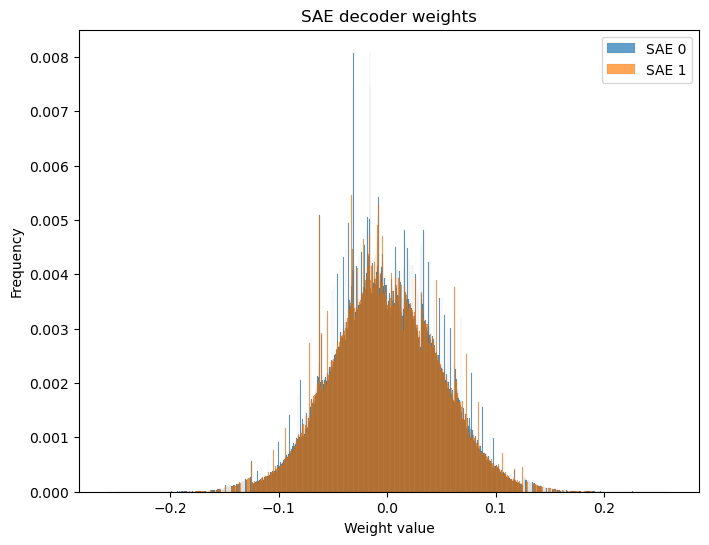

In [23]:
"""Visualize decoder weights."""

n_inst = sae.cfg.n_instances

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

### Validate feature sparsity (L0)

In [101]:
"""Validate SAE feature sparsity."""

n_units = spike_counts.shape[1]
n_examples = spike_counts.shape[0]
batch_sz = 1024
seq_len = 1
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
valid_starts = n_examples - seq_len + 1
l0 = t.zeros(((n_steps * batch_sz), n_inst), dtype=t.float32, device=device)
recon_spk_cts = t.empty((n_recon_examples, n_inst, n_units), dtype=bfloat16, device=device)
# all_acts = t.empty((n_recon_examples, n_inst, sae.cfg.n_hidden_ae), dtype=bfloat16, device=device)

progress_bar = tqdm(range(n_steps))
with t.no_grad():
    for step in progress_bar:
        # Get proper indices corresponding to step
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        x_prime, h = sae(spike_count_seqs)
        nonzero_mask = (h.abs() > 1e-7).float()
        cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
        l0[idxs[:, 0]] = cur_l0
        recon_spk_cts[idxs[:, 0]] = x_prime
        # all_acts[idxs[:, 0]] = z

# all_acts = asnumpy(all_acts.float())

  0%|          | 0/178 [00:00<?, ?it/s]

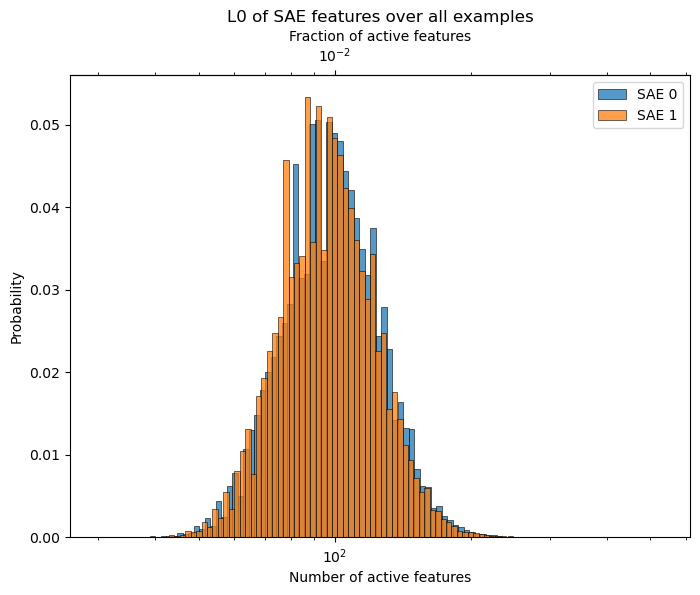

In [102]:
fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    sns.histplot(
        asnumpy(l0[:, inst]),
        bins=100,
        log_scale=10,
        stat="probability",
        ax=ax,
        label=f"SAE {inst}"
    )

ax.set_xlabel("Number of active features")
ax.set_ylabel("Probability")

secax = ax.secondary_xaxis(
    "top", 
    functions=(lambda x: x / sae.cfg.n_hidden_ae, lambda x: x * sae.cfg.n_hidden_ae)
)
secax.set_xlabel('Fraction of active features')

ax.set_title("L0 of SAE features over all examples")
ax.legend(["SAE 0", "SAE 1"])

### Validate that the reconstructions are good

In [103]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_counts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.984
SAE instance 1 R² (summed spike count over all units per example) = 0.983


C:\Users\jai\AppData\Local\Temp\ipykernel_33536\1131461802.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"SAE {i}" for i in range(n_inst)])


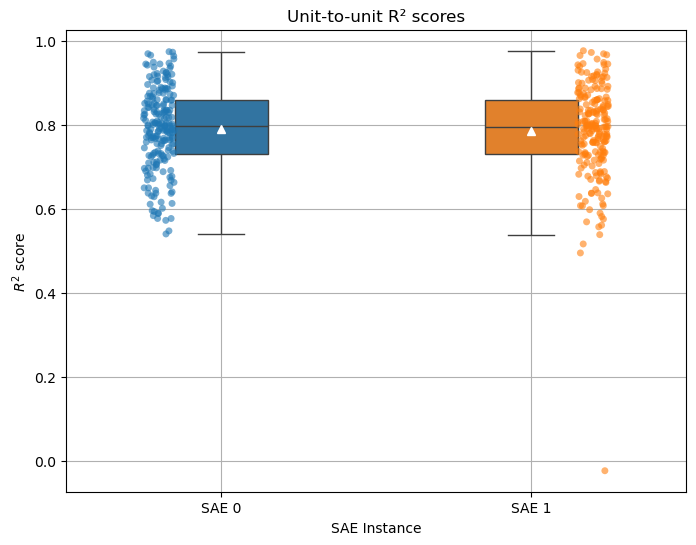

In [104]:
"""Calculate var explained for each neuron."""

r2_neuron = np.empty((n_inst, n_units))
for inst in range(n_inst):
    for unit in range(n_units):
        r2_neuron[inst, unit] = r2_score(
            asnumpy(spike_counts[0:n_recon_examples, unit].float()),
            asnumpy(recon_spk_cts[:, inst, unit].float())
        )
data = [r2_neuron[i] for i in range(n_inst)]

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    data=data,
    width=0.3,
    showfliers=False,
    showmeans=True,
    meanprops={
        "markeredgecolor": "white",
        "markerfacecolor": "white",
        "markersize": "6"
    },
    ax=ax
)
sns.stripplot(
    data=data,
    alpha=0.6,
    jitter=True,
    dodge=True,
    ax=ax,
)

# Customize the plot labels and title
ax.set_xlabel("SAE Instance")
ax.set_ylabel("$R^2$ score")
ax.set_title("Unit-to-unit R² scores")
ax.set_xticklabels([f"SAE {i}" for i in range(n_inst)])
# ax.set_yticks(np.arange(-0.6, 1.1, 0.1))
# ax.set_ylim(-0.6, 1.0)
ax.grid(True)

In [105]:
r2_thresh = 0.5
n_units_gt_r2_thresh = sum(data[0] > r2_thresh)
frac_units_gt_r2_thresh = n_units_gt_r2_thresh / n_units
print(f"{n_units_gt_r2_thresh=}, {frac_units_gt_r2_thresh=}")

n_units_gt_r2_thresh=217, frac_units_gt_r2_thresh=1.0


In [ ]:
_inst_idxs, bad_neuron_idxs = np.where(r2_neuron < 0.5)
print(f"{_inst_idxs=}, {bad_neuron_idxs=}")
good_neuron_idxs = np.setdiff1d(np.arange(n_units), bad_neuron_idxs)
orig_unit_idxs = region_units["cluster_id"].iloc[good_neuron_idxs]
# remove bad_neuron_idxs from spike_counts cols
# spike_counts = spike_counts[:, good_neuron_idxs]

_inst_idxs=array([1, 1], dtype=int64), bad_neuron_idxs=array([ 67, 202], dtype=int64)


In [ ]:
"""Calculate cosine similarity between recon and actual for each exmample."""

batch_sz = 128
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
cos_sim = t.empty((n_recon_examples, n_inst)).to(device)

# This requires too mach memory, so we have to batch it.
# for inst in range(n_inst):
#   cos_sim[:, inst] = F.cosine_similarity(
#       rearrange(spike_counts[0:n_recon_examples], "example unit -> example 1 unit"),
#       recon_spk_cts[:, inst, :],
#       dim=2,
#   )

pbar = tqdm(range(n_steps))
for step in pbar:
    # Get proper indices corresponding to step
    idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
    cos_sim[idxs, :] = t.cosine_similarity(
        repeat(spike_counts[idxs, :], "example unit -> example inst unit", inst=n_inst),
        recon_spk_cts[idxs, :, :],
        dim=2
    ).float()

cos_sim = asnumpy(cos_sim)

In [ ]:
"""Plot cosine similarities."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    sns.histplot(cos_sim[:, inst], bins=1000, stat="probability", ax=ax, label=f"SAE {inst}")

ax.set_xlabel("Cosine similarity")
ax.set_ylabel("Probability")
ax.set_title("Cosine similarity between actual and reconstructed spike counts")
ax.legend(["SAE 0", "SAE 1"])
ax.set_xlim(0.4, 1.0)

## Create a single figure with validation results

In [17]:
def vec_r2(y_pred: Float[Tensor, "n inst feat"], y_true: Float[Tensor, "n feat"]) -> (
    Float[Tensor, "n"]
):
    """Calculates vectorized R² scores for each example in a batch."""
    # Calculate SST
    y_true_mean = reduce(y_true, "n feat -> n", "mean")
    ss_tot = reduce((y_true - y_true_mean.unsqueeze(-1)) ** 2, "n feat -> n", "sum")
    # Calculate SSR
    y_true = repeat(y_true, "n feat -> n inst feat", inst=y_pred.shape[1])  # match to broadcast
    ss_res = reduce((y_true - y_pred) ** 2, "n inst feat -> n inst", "sum")
    
    return 1 - (ss_res / ss_tot.unsqueeze(-1))
    

In [22]:
"""Run examples through model."""

seq_len = 1
batch_sz = 1024

# Set some constants.
n_inst = sae.cfg.n_instances
n_units = spike_counts.shape[1]
n_examples = spike_counts.shape[0]
valid_starts = n_examples - seq_len + 1
n_steps = valid_starts // batch_sz  # total number of examples
n_recon_examples = n_steps * batch_sz

# Create tensors to store L0 and reconstructions.
l0 = t.zeros((n_recon_examples, n_inst), dtype=t.float32, device=device)
recon_spk_cts = t.empty((n_recon_examples, n_inst, n_units), dtype=bfloat16, device=device)

# Create tensors to store eval metrics.
r2_per_example = t.empty((n_recon_examples, n_inst), dtype=bfloat16, device=device)
cos_sim_per_example = t.empty((n_recon_examples, n_inst), dtype=bfloat16, device=device)

progress_bar = tqdm(range(n_steps))
with t.no_grad():
    for step in progress_bar:  # loop over all examples
        # Get start index for each seq in batch, and then get the full seq indices.
        start_idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        seq_idxs = repeat(start_idxs, "batch -> batch inst", inst=n_inst)
        seq_idxs = seq_idxs.unsqueeze(-1) + t.arange(seq_len)  # broadcast to seq dim
        spike_count_seqs = spike_counts[seq_idxs]  # [batch, inst, seq, unit]
        # Forward pass through SAE.
        x_prime, h = sae(spike_count_seqs)
        nonzero_mask = (h.abs() > 1e-7).float()
        cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
        # Store results.
        l0[start_idxs] = cur_l0
        recon_spk_cts[start_idxs] = x_prime
        # Calculate metrics for examples.
        r2_per_example[start_idxs] = vec_r2(x_prime, spike_counts[start_idxs])
        cos_sim_per_example[start_idxs] = (
            t.cosine_similarity(x_prime, spike_counts[start_idxs].unsqueeze(1), dim=-1)
        )

r2_per_example[~t.isfinite(r2_per_example)] = 0.0  # div by 0 cases

# Calculate metrics for units.
cos_sim_per_unit = t.empty((n_units, n_inst))
r2_per_unit = np.empty((n_units, n_inst))

spike_counts_np = asnumpy(spike_counts.float())
recon_spk_cts_np = asnumpy(recon_spk_cts.float())

pbar_unit = tqdm(range(n_units))
for unit in pbar_unit:
    cos_sim_per_unit[unit] = t.cosine_similarity(
        recon_spk_cts[..., unit], spike_counts[:n_recon_examples, unit].unsqueeze(-1), dim=0
    )
    for inst in range(n_inst):
        r2_per_unit[unit, inst] = r2_score(
            spike_counts_np[:n_recon_examples, unit], recon_spk_cts_np[:, inst, unit]
        )


  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

C:\Users\jai\AppData\Local\Temp\ipykernel_57564\4154681411.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_l0.set_xticklabels([f"SAE {i}" for i in range(n_inst)])


(0.0, 250.0)

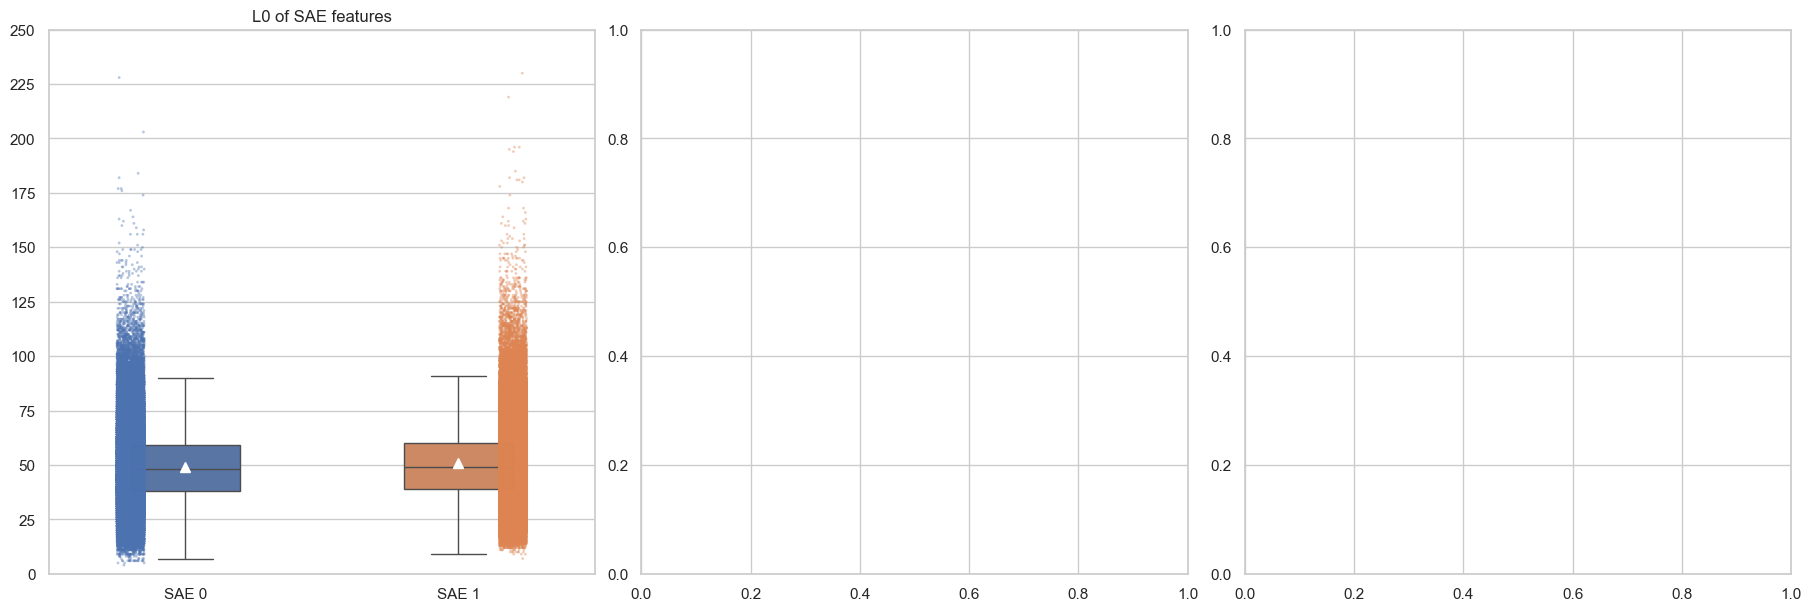

In [94]:
"""L0 boxplot."""

fig, (ax_l0, ax_r2, ax_cos) = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
sns.set(style="whitegrid")

l0_data = [asnumpy(l0[:, i]) for i in range(n_inst)]
sns.boxplot(
    data=l0_data,
    width=0.4,
    showfliers=False,
    showmeans=True,
    meanprops={"markersize": "7", "markerfacecolor": "white", "markeredgecolor": "white"},
    ax=ax_l0,
)
sns.stripplot(
    data=l0_data,
    size=2,
    alpha=0.4,
    jitter=True,
    dodge=True,
    ax=ax_l0,
)
ax_l0.set_xlabel("")
ax_l0.set_ylabel("")
ax_l0.set_title("L0 of SAE features")
ax_l0.set_xticklabels([f"SAE {i}" for i in range(n_inst)])
ax_l0.set_yticks(np.arange(0, l0.max().item() + 1, sae.cfg.topk // 2))
ax_l0.set_ylim(0, 250)

In [ ]:
"""Convert r2 and cos data to numpy for plotting."""

cos_sim_per_example = asnumpy(cos_sim_per_example.float())
r2_per_example = asnumpy(r2_per_example.float())
cos_sim_per_unit = asnumpy(cos_sim_per_unit.float())


In [ ]:
"""Format r2 and cos data for seaborn."""

model_names = [f"SAE {i}" for i in range(2)]
dfs = []

dfs.append(
    pd.DataFrame(cos_sim_per_example, columns=model_names)
    .melt(var_name="SAE", value_name="Value")
    .assign(Type="Examples", Metric="Cosine Similarity")
)

dfs.append(
    pd.DataFrame(cos_sim_per_unit, columns=model_names)
    .melt(var_name="SAE", value_name="Value")
    .assign(Type="Units", Metric="Cosine Similarity")
)

dfs.append(
    pd.DataFrame(r2_per_example, columns=model_names)
    .melt(var_name="SAE", value_name="Value")
    .assign(Type="Examples", Metric="R²")
)

dfs.append(
    pd.DataFrame(r2_per_unit, columns=model_names)
    .melt(var_name="SAE", value_name="Value")
    .assign(Type="Units", Metric="R²")
)

df = pd.concat(dfs, ignore_index=True)

cos_sim_df = df[df["Metric"] == "Cosine Similarity"]
r2_df = df[df["Metric"] == "R²"]

display(df)

,SAE,Value,Type,Metric
0,SAE 0,0.000000,Examples,Cosine Similarity
1,SAE 0,0.000000,Examples,Cosine Similarity
2,SAE 0,0.000000,Examples,Cosine Similarity
3,SAE 0,0.000000,Examples,Cosine Similarity
4,SAE 0,0.000000,Examples,Cosine Similarity
...,...,...,...,...
729987,SAE 1,0.690624,Units,R²
729988,SAE 1,0.715714,Units,R²
729989,SAE 1,0.685354,Units,R²
729990,SAE 1,0.449216,Units,R²


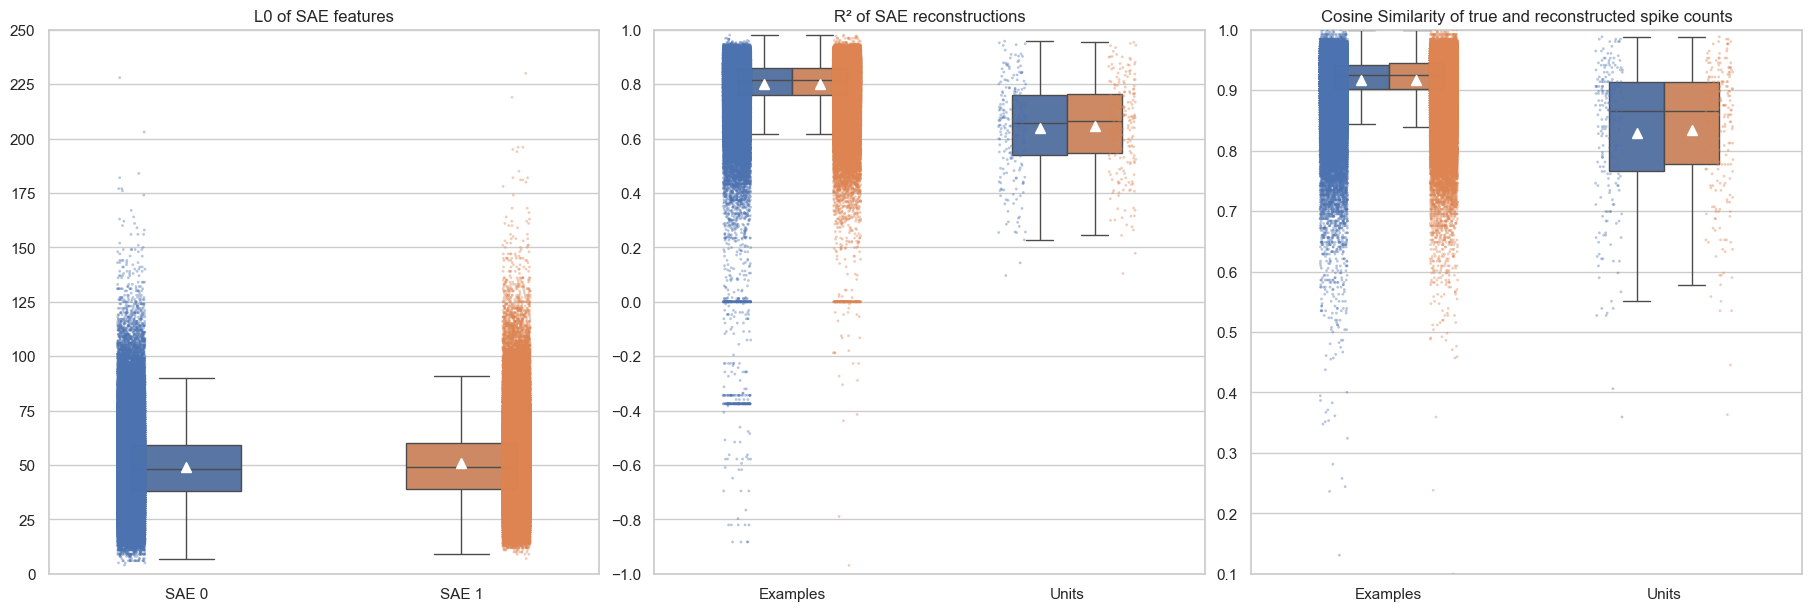

In [95]:
"""Add r2 and cos plots to figure."""

sns.boxplot(
    data=r2_df,
    x="Type", 
    y="Value", 
    hue="SAE",
    width=0.4,
    showfliers=False,
    showmeans=True,
    meanprops={"markersize": "7", "markerfacecolor": "white", "markeredgecolor": "white"},
    legend=False,
    ax=ax_r2,
)
sns.stripplot(
    data=r2_df,
    x="Type",
    y="Value",
    hue="SAE",
    size=2,
    alpha=0.4,
    dodge=True, 
    jitter=True,
    legend=False,
    ax=ax_r2,
)

ax_r2.set_title("R² of SAE reconstructions")
ax_r2.set_ylabel("")
ax_r2.set_xlabel("")
ax_r2.set_ylim(-1.0, 1.0)
ax_r2.set_yticks(np.arange(-1.0, 1.1, 0.2))

sns.boxplot(
    data=cos_sim_df,
    x="Type", 
    y="Value", 
    hue="SAE",
    width=0.4,
    showfliers=False,
    showmeans=True,
    meanprops={"markersize": "7", "markerfacecolor": "white", "markeredgecolor": "white"},
    legend=False,
    ax=ax_cos,
)
sns.stripplot(
    data=cos_sim_df,
    x="Type",
    y="Value",
    hue="SAE",
    size=2,
    alpha=0.4,
    dodge=True, 
    jitter=True,
    legend=False,
    ax=ax_cos,
)

ax_cos.set_title("Cosine Similarity of true and reconstructed spike counts")
ax_cos.set_ylabel("")
ax_cos.set_xlabel("")
ax_cos.set_ylim(0.1, 1.0)
ax_cos.set_yticks(np.arange(0.1, 1.1, 0.1))

fig

In [ ]:
"""Get all times of light flashes, rank features by mean activation value."""

session_stim_data = session_data.get_stimulus_table()
all_flashes = session_stim_data[session_stim_data["stimulus_name"] == "flashes"]
light_flashes = all_flashes[all_flashes["color"] > 0]
flash_times_light = []
for _, row in light_flashes.iterrows():
    cur_stim_times = np.unique(np.arange(row["start_time"], row["stop_time"], win).round(round_to))
    flash_times_light.extend(cur_stim_times)
counts_flash_df = counts_df.loc[flash_times_light]
spk_cts_l_f = t.from_numpy(counts_flash_df.values).bfloat16().to(device)

feat_flash_acts = t.empty(
    (len(counts_flash_df), n_inst, sae.cfg.n_hidden_ae), dtype=t.bfloat16, device=device
)

batch_sz = 32
n_steps = len(counts_flash_df) // batch_sz
pbar = tqdm(range(n_steps))

with t.no_grad():
    for step in pbar:
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spk_cts_l_f[seq_idxs]
        spike_count_seqs = rearrange(
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )
        _l1_loss, _l2_loss, _loss, z, _x_prime = sae.forward(spike_count_seqs)
        feat_flash_acts[idxs[:, 0]] = z

feat_flash_acts_mean = reduce(feat_flash_acts, "example inst hidden_ae -> inst hidden_ae", "mean")

k = 2
topk_feat_vals, topk_feat_idxs = feat_flash_acts_mean.topk(k)

topk_feat_idxs = asnumpy(topk_feat_idxs)
feat_flash_acts = asnumpy(feat_flash_acts.float())

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     93925
        True       0.85      0.81      0.83       225

    accuracy                           1.00     94150
   macro avg       0.93      0.90      0.92     94150
weighted avg       1.00      1.00      1.00     94150



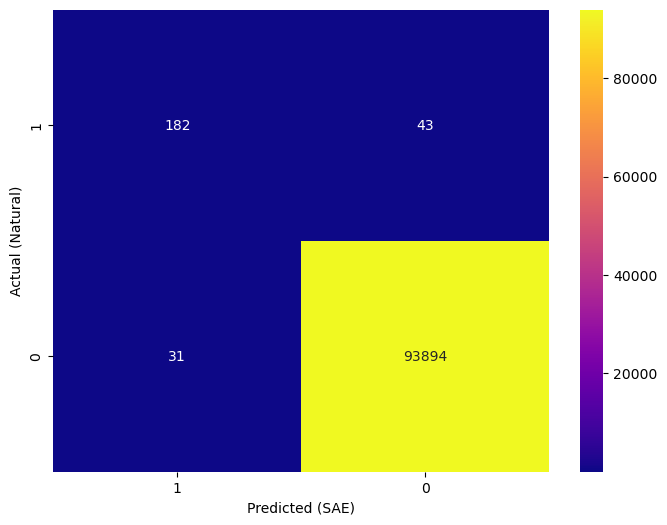

In [ ]:
"""Create a confusion matrix for sae-natural feature co-occurrence."""

spike_counts = counts.to_dense().bfloat16().to(device)
batch_sz = 256
seq_len = 1
n_steps = spike_counts.shape[0] // batch_sz
n_recon_examples = n_steps * batch_sz
valid_starts = n_examples - seq_len + 1
l0 = t.zeros(((n_steps * batch_sz), n_inst), dtype=t.int32)
recon_spk_cts = t.empty((n_recon_examples, n_inst, n_units), dtype=bfloat16)
all_acts = t.empty((n_recon_examples, n_inst, sae.cfg.n_hidden_ae), dtype=bfloat16)

progress_bar = tqdm(range(n_steps))
with t.no_grad():
    for step in progress_bar:
        # Get proper indices corresponding to step
        idxs = t.arange(step * batch_sz, (step + 1) * batch_sz)
        idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
        # broadcast idxs for each sequence to a new dimension
        seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
        spike_count_seqs = spike_counts[seq_idxs]
        spike_count_seqs = rearrange(  # format for Sae
            spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
        )
        _l1_loss, _l2_loss, _loss, z, x_prime = sae.forward(spike_count_seqs)
        nonzero_mask = z.abs() > 1e-6
        cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum").to(t.int32)
        l0[idxs[:, 0]] = cur_l0.to("cpu")
        recon_spk_cts[idxs[:, 0]] = x_prime.to("cpu")
        all_acts[idxs[:, 0]] = z.to("cpu")

# For each time the sae feature ("predicted" class) fires above a threshold activation value, 
# see how often the natural feature ("actual" class) is present, and vice versa.

act_thresh = 12
sae_feat_acts_mask = all_acts[:, 0, topk_feat_idxs[0, 0]] > act_thresh
sae_feat_times = counts_df.index.values[0:len(sae_feat_acts_mask)][sae_feat_acts_mask]
nat_feat_times = counts_flash_df.index.values
all_times = counts_df.index.values

nat_present = np.isin(all_times, nat_feat_times)
sae_present = np.isin(all_times, sae_feat_times)
cm = np.flip(confusion_matrix(nat_present, sae_present))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt="d",  # as int
    cmap="plasma",  # Color map
    xticklabels=["1", "0"],
    yticklabels=["1", "0"],
    ax=ax
)
ax.set_xlabel("Predicted (SAE)")
ax.set_ylabel("Actual (Natural)")

print(classification_report(nat_present, sae_present))

## Scratchpad below here

In [ ]:
def batched_forward_pass(
    spike_counts: Int[Tensor, "n_examples n_units"],
    sae: Sae, 
    batch_sz: int, 
    seq_len: int, 
    device: str = "cuda"
) -> tuple[
    Int[Tensor, "n_examples n_inst"], 
    Float[Tensor, "n_examples n_inst n_units"], 
    Float[Tensor, "n_examples n_inst n_hidden_ae"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"],
    Float[Tensor, "n_examples n_inst"]
]:
    """Perform batched forward pass through SAE model.
    
    Returns a tuple containing:
        - L0 (number of active features per example)
        - Reconstructed spike counts per example
        - Hidden layer activations per example
        - L1 loss per example
        - L2 loss per example
        - Total loss per example
    """
    # Initialize batches.
    n_examples, n_units = spike_counts.shape[0], spike_counts.shape[1]
    n_inst = sae.cfg.n_instances
    n_full_batches, final_batch_sz = n_examples // batch_sz, n_examples % batch_sz
    n_steps = n_full_batches + (1 if final_batch_sz > 0 else 0)
    
    # Initialize output tensors.
    l0 = t.zeros((n_examples, n_inst), dtype=t.float32, device=device)
    recon_spk_cts = t.empty((n_examples, n_inst, n_units), dtype=t.bfloat16, device=device)
    h_acts = t.empty((n_examples, n_inst, sae.cfg.n_hidden_ae), dtype=t.bfloat16, device=device)
    l1_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    l2_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    total_losses = t.empty((n_examples, n_inst), dtype=t.bfloat16, device=device)
    
    progress_bar = tqdm(range(n_steps))
    with t.no_grad():
        for step in progress_bar:
            # Set up for forward pass.
            cur_batch_size = batch_sz if step < n_full_batches else final_batch_sz
            start_idx = step * batch_sz
            end_idx = start_idx + cur_batch_size
            idxs = t.arange(start_idx, end_idx)
            idxs = repeat(idxs, "batch -> batch inst", inst=n_inst)
            # broadcast idxs for each sequence to a new dimension
            seq_idxs = idxs.unsqueeze(-1) + t.arange(seq_len)
            spike_count_seqs = spike_counts[seq_idxs]
            spike_count_seqs = rearrange(
                spike_count_seqs, "batch inst seq unit -> (batch seq) inst unit"
            )
            
            # Compute reconstructions, hidden layer activations, and losses.
            l1_loss, l2_loss, loss, z, x_prime = sae(spike_count_seqs)
            
            # Compute L0.
            nonzero_mask = (z.abs() > 1e-7).float()
            cur_l0 = reduce(nonzero_mask, "batch inst sae_feat -> batch inst", "sum")
            
            # Store results
            l0[idxs[:, 0]] = cur_l0
            recon_spk_cts[idxs[:, 0]] = x_prime
            h_acts[idxs[:, 0]] = z
            l1_losses[idxs[:, 0]] = l1_loss
            l2_losses[idxs[:, 0]] = l2_loss
            total_losses[idxs[:, 0]] = loss
    
    return l0, recon_spk_cts, h_acts, l1_losses, l2_losses, total_losses